# **Jigsaw Comment Classification**

It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet. 

**This notebook contains the process of building NLP Multilingual Classification Models with BERT (Bidirectional Encoder Representations from Transformers: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1) technologies and TPU (network-connected accelerators: https://www.kaggle.com/docs/tpu) to accelarate the extensive training process. The models are trained with English-only training data and tested/validated on multilingual testing data.**


In [1]:
import os

import numpy as np
import pandas as pd
import transformers
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from kaggle_datasets import KaggleDatasets
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

import seaborn as sns
import matplotlib.pyplot as plt

**Functions**

In [2]:
def regEncode(txt, token, maxL=512):
    encoD = token.batch_encode_plus(txt,return_attention_masks=False,return_token_type_ids=False,pad_to_max_length=True,
                                     max_length=maxL)
    
    return np.array(encoD['input_ids'])

In [3]:
def advEncode(txt, token, maxL=512, chunkSize=256):
    token.enable_truncation(max_length=maxL)
    token.enable_padding(max_length=maxL)
    IDs = []
    
    for x in tqdm(range(0, len(txt), chunkSize)):
        txtChunk = txt[x:x+chunkSize].tolist()
        encds = token.encode_batch(txtChunk)
        IDs.extend([encd.ids for encd in encds])
    
    return np.array(IDs)

In [4]:
def modelDev(transformer, maxL=512):
    inputWordIDs = Input(shape=(maxL,), dtype=tf.int32, name="input_word_ids")
    seqOutput = transformer(inputWordIDs)[0]
    classToken = seqOutput[:, 0, :]
    output = Dense(1, activation='sigmoid')(classToken)
    
    model = Model(inputs=inputWordIDs, outputs=output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

**TPU Configurations**

In [5]:
# Detecting hardware
# Producing appropriate distro strategy
try:
    # TPU detection
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU: ', TPU.master())
except ValueError:
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strat = tf.distribute.experimental.TPUStrategy(TPU)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strat = tf.distribute.get_strategy()

print("Replicas - ", strat.num_replicas_in_sync)

Running on TPU:  grpc://10.0.0.2:8470
Replicas -  8


In [6]:
AUTO = tf.data.experimental.AUTOTUNE

# Accessing data
DS_PATH_GCS = KaggleDatasets().get_gcs_path()

# Config
EPOCHS = 2
BATCH_SIZE = 16 * strat.num_replicas_in_sync
MAX_L = 192
MODEL = 'jplu/tf-xlm-roberta-large'

**Creating Tokenizer**

In [7]:
# Loading the real tokenizer
nTokenizer = AutoTokenizer.from_pretrained(MODEL)

**Loading Textual Data**

In [8]:
trainTC = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
trainUB = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
trainUB.toxic = trainUB.toxic.round().astype(int)

valDS = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
testDS = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
submissionDS = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [9]:
# Merge trainTC with a subset of trainUB
trainDS = pd.concat([trainTC[['comment_text', 'toxic']],trainUB[['comment_text', 'toxic']].query('toxic==1')
                     ,trainUB[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)])

In [10]:
trainDS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435775 entries, 0 to 921647
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  435775 non-null  object
 1   toxic         435775 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.0+ MB


In [11]:
trainDS.head(20)

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [12]:
# distribution of target
print(trainDS.toxic.value_counts())

def TragetDist(Train):
    Toxic ={"1": sum(Train[Train.toxic == 1].toxic.value_counts())}
    Not_toxic = {"0": sum(Train[Train.toxic == 0].toxic.value_counts())}

    fig, ax = plt.subplots(figsize=(8,5))

    ax.bar(Not_toxic.keys(), Not_toxic.values(), label="Not Toxic")
    ax.bar(Toxic.keys(), Toxic.values(), label="Toxic")
    plt.title("Target distribution")
    plt.xlabel("Category")
    plt.ylabel("Number of samples")
    ax.legend()

    plt.show()

0    302165
1    133610
Name: toxic, dtype: int64


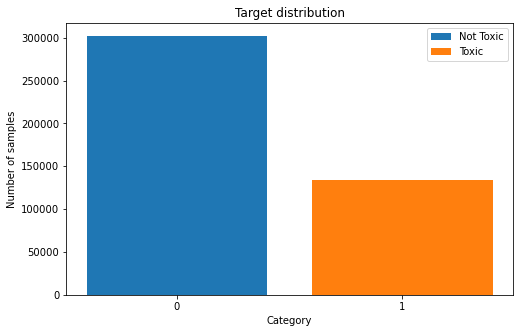

In [13]:
TragetDist(trainDS)

As we can see, the classes are imbalanced, in order resolve this issue the upsampling/downsampling needs to be applied.

In [14]:
# As shown in the graph, Non-toxic class examples are dominating the Train DS
# Therefore, downsampling the Majority class rows
from sklearn.utils import resample

df_majority = trainDS[trainDS.toxic==0]
df_minority = trainDS[trainDS.toxic==1]
 
# Down-sample majority class
df_majority_downsample = resample(df_majority, replace=False,     # sample with replacement
                                  n_samples=133610,    # to match minority class
                                  random_state=123) # reproducible results
 
# Combine majority class with Down-sample majority class
df_dsampled = pd.concat([df_majority_downsample, df_minority])

1    133610
0    133610
Name: toxic, dtype: int64


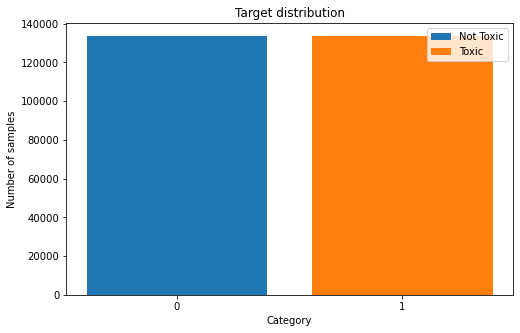

In [15]:
print(df_dsampled.toxic.value_counts())
TragetDist(df_dsampled)

In [16]:
# words per comment
def word_per_comment_vis(Train):
    toxic_uniques = Train[Train.toxic==1].comment_text.str.split().map(lambda x: len(x))
    non_toxic_uniques = Train[Train.toxic==0].comment_text.str.split().map(lambda x: len(x))

    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].hist(non_toxic_uniques, color="blue")
    axs[1].hist(toxic_uniques, color="red")

    axs[0].set_title("Not Toxic")
    axs[1].set_title("Toxic")
    fig.suptitle("Words per comment")

    plt.show()
    
# average length per word
def avgLen_word_vis(Train):
    toxic_word_len = Train[Train.toxic==1].comment_text.str.split().apply(lambda x : [len(i) for i in x])
    non_toxic_word_len = Train[Train.toxic==0].comment_text.str.split().apply(lambda x : [len(i) for i in x])

    fig, axs = plt.subplots(1,2, figsize=(15,5))
    sns.distplot(non_toxic_word_len.map(lambda x: np.mean(x)), ax=axs[0], color="blue")
    sns.distplot(toxic_word_len.map(lambda x: np.mean(x)), ax=axs[1], color="red")

    axs[0].set_title("Not Toxic")
    axs[1].set_title("Toxic")
    fig.suptitle("Average word length per comment")

    plt.show()
    
# characters per comment
def char_per_comment_vis(Train):
    toxic_len = Train[Train.toxic==1].comment_text.str.len()
    not_toxic_len = Train[Train.toxic==0].comment_text.str.len()

    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].hist(not_toxic_len, color="blue")
    axs[1].hist(toxic_len, color="red")

    axs[0].set_title("Not Toxic")
    axs[1].set_title("Toxic")
    fig.suptitle("Characters per comment")

    plt.show()

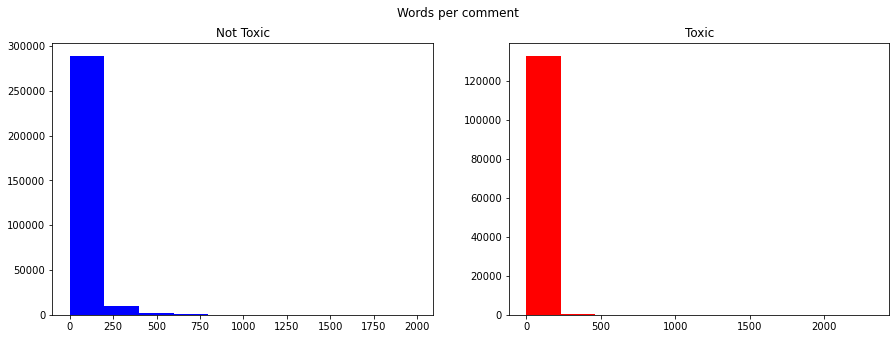

In [17]:
# Number of words per comment
word_per_comment_vis(trainDS)

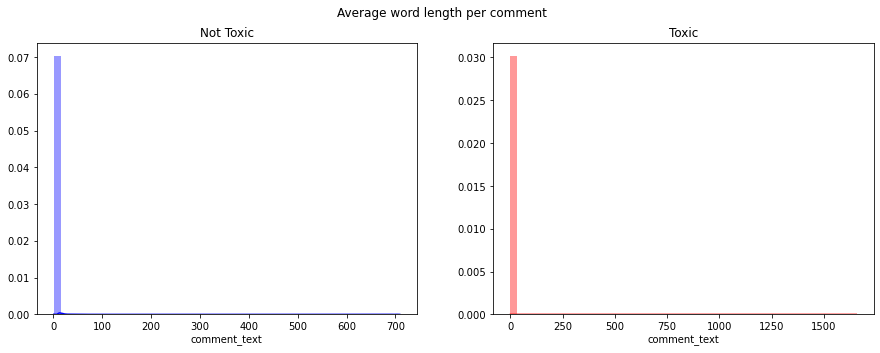

In [18]:
# Average length per word
avgLen_word_vis(trainDS)

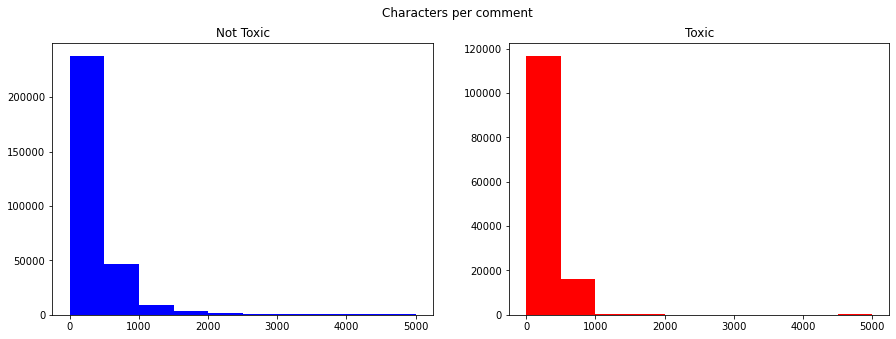

In [19]:
# characters per comment
char_per_comment_vis(trainDS)

In [20]:
# import required libraries for NLP
import re
import string
import nltk
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import flatten

In [23]:
def create_corpus(df, toxic=None, var=str, full_corpus=False): 
    """
    Performs TweetTokenizer() from nltk and creates a corpus based on the distinct target group.
    When full_corpus=True or when target==None then a corpus without the
    distinct target group would be created.
    
    Parameters
    ----------
    df: DataFrame that contains text 
    var: The variable that contains the text to be processed
    Toxic: The distinct category group should be created based on
    test: bool, when true a corpus for test set will be created
    
    Returns
    -------
    A corpus as a list
    """
    x = df.copy()
    
    # removing html
    x["comment_text"] = x["comment_text"].apply(lambda y: re.split(r"http\S+", str(y))[0])
    
    if full_corpus==True or toxic==None:
        corpus = flatten([TweetTokenizer(strip_handles=True).tokenize(i.lower()) for i in x[var].tolist()])
    else: 
        corpus = flatten([TweetTokenizer(strip_handles=True).tokenize(i.lower()) for i in x[x["toxic"]==toxic].comment_text])
    return corpus

def extract_punctuation(corpus):
    """
    Extracts punctuation from the corpus.
    
    Parameters
    ----------
    corpus: list of tokens
    
    Returns
    -------
    A sorted dictionary which has the keys as the unique special character
    and the values is the amount of times that distinct key occurs within the corpus. 
    """
    dictionary = defaultdict(int)
    for i in corpus:
        if i in string.punctuation:
            dictionary[i] += 1
    return dictionary


def plot_dict_freq(dictionary):
    """
    Visualization of keys and their frequency.
    
    Parameters
    ----------
    dictionary: A dictionary type
    
    Returns
    -------
    The visualization of the frequency with respect to the unique key.
    """
    x, y = zip(*dictionary.items())
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(x, y)
    plt.ylabel("Frequency")

    return plt.show()

In [24]:
# creating a corpus of words based on the target 
toxic_corpus = create_corpus(df=trainDS, var="comment_text", toxic=1)
non_toxic_corpus = create_corpus(df=trainDS, var="comment_text", toxic=0)

# corpus of full train
train_corpus = create_corpus(df=trainDS, var="comment_text", full_corpus=True)

# extracting punctuation counts
toxic_corpus_punc = extract_punctuation(toxic_corpus)
non_toxic_corpus_punc = extract_punctuation(non_toxic_corpus)

full_train_corpus_punc = extract_punctuation(train_corpus)

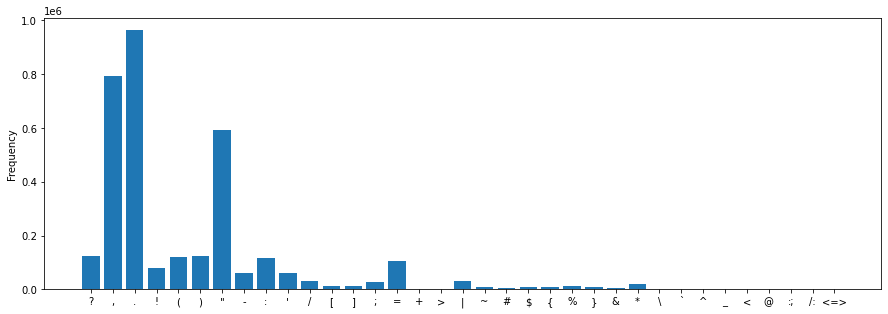

In [28]:
# visualising the frequency of a special character in non-toxic tweets
plot_dict_freq(non_toxic_corpus_punc)

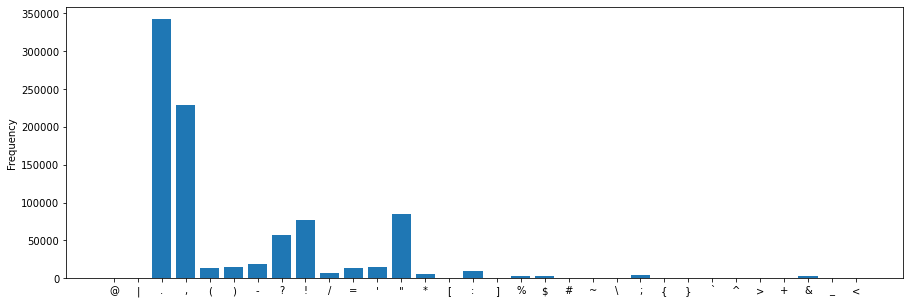

In [30]:
# visualising the frequency of a special character in toxic tweets
plot_dict_freq(toxic_corpus_punc)

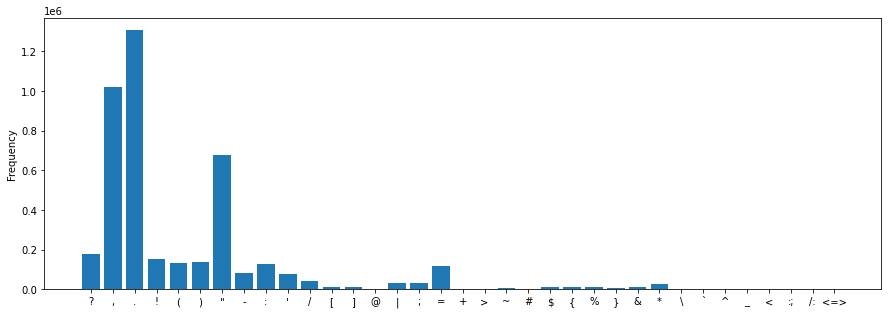

In [29]:
# visualizing the frequency of a special character in full train set corpus
plot_dict_freq(full_train_corpus_punc)

In [31]:
def get_top_n_words(corpus, ngrams=(1,1), n=None):
    """
    List the top n ngrams in corpus according to counts.
    
    Parameters
    ----------
    corpus: Text to be counted in Bag of Words
    ngrams: Amount of n words. ngrams=(min, max)
    n: Number of n words to display
    
    Returns
    -------
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),

('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(ngram_range=ngrams).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [32]:
stp = stopwords.words('english')
stp_wrds_ = set(stp)

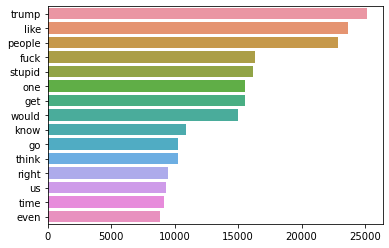

In [34]:
# Top 15 unigrams when there is a toxic commment
# remove stopwods (using NLTK stopwords)
filtered_toxic_corpus = [word for word in toxic_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_toxic_corpus, ngrams=(1,1), n=15)))
sns.barplot(x=y, y=x)
plt.show()

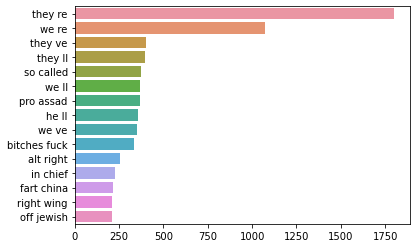

In [35]:
# Top 15 bigrams when there is a toxic comment
filtered_toxic_corpus = [word for word in toxic_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_toxic_corpus, ngrams=(2,2), n=15)))
sns.barplot(x=y, y=x)
plt.show()

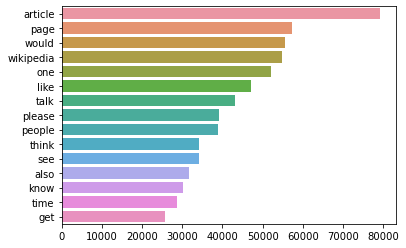

In [36]:
# Top 15 unigrams for non-toxic comment
# removing stopwords
filtered_non_toxic_corpus = [word for word in non_toxic_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_non_toxic_corpus, ngrams=(1,1), n=15)))
sns.barplot(x=y, y=x)
plt.show()

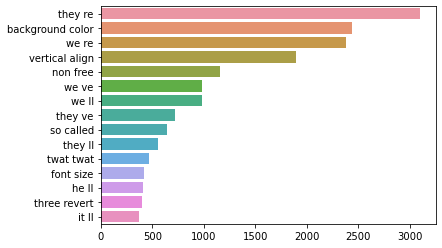

In [37]:
# Top 15 bigrams when there is a non-toxic tweet
filtered_non_toxic_corpus = [word for word in non_toxic_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_non_toxic_corpus, ngrams=(2,2), n=15)))
sns.barplot(x=y, y=x)
plt.show()

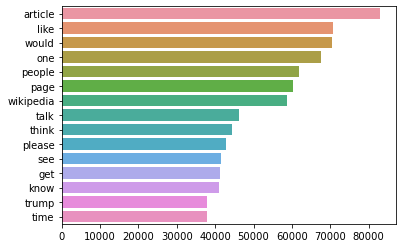

In [38]:
# Top 15 unigrams in full train corpus
filtered_train_corpus = [word for word in train_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_train_corpus, n=15)))
sns.barplot(x=y, y=x)
plt.show()

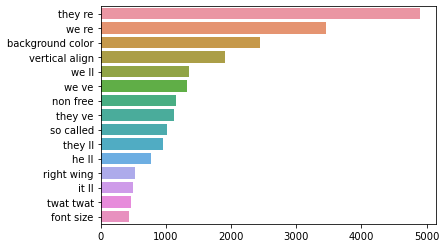

In [40]:
# Top 15 bigrams in full train corpus
filtered_train_corpus = [word for word in train_corpus if word not in stp_wrds_]
x,y = map(list, zip(*get_top_n_words(filtered_train_corpus, ngrams=(2,2), n=15)))
sns.barplot(x=y, y=x)
plt.show()

In [41]:
%%time 

Xtrain = regEncode(df_dsampled.comment_text.values, nTokenizer, maxL=MAX_L)
Xvalid = regEncode(valDS.comment_text.values, nTokenizer, maxL=MAX_L)
Xtest = regEncode(testDS.content.values, nTokenizer, maxL=MAX_L)

yTrain = df_dsampled.toxic.values
yValid = valDS.toxic.values

CPU times: user 4min 16s, sys: 783 ms, total: 4min 17s
Wall time: 4min 17s


**Creating Dataset Objects**

In [44]:
trainDs = tf.data.Dataset.from_tensor_slices((Xtrain, yTrain)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)

validDs = tf.data.Dataset.from_tensor_slices((Xvalid, yValid)).batch(BATCH_SIZE).cache().prefetch(AUTO)

testDs = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE)

**Loading Model on the TPU**

In [54]:
%%time
with strat.scope():
    transformerLayer = TFAutoModel.from_pretrained(MODEL)
    model = modelDev(transformerLayer, maxL=MAX_L)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model_1 (TFRobert ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 33.7 s, sys: 27.9 s, total: 1min 1s
Wall time: 1min 25s


**Training**

Initially training the model on the English subset of the Training set.

In [55]:
nSteps = Xtrain.shape[0] // BATCH_SIZE
training = model.fit(trainDs,steps_per_epoch = nSteps,validation_data = validDs,epochs = EPOCHS)

Train for 2087 steps, validate for 63 steps
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


2087/2087 [==============================] - 1203s 577ms/step - loss: 0.0188 - accuracy: 0.9924 - val_loss: 0.5294 - val_accuracy: 0.8463
Epoch 2/2
2087/2087 [==============================] - 992s 475ms/step - loss: 0.0320 - accuracy: 0.9891 - val_loss: 0.7337 - val_accuracy: 0.1641


Since we have trained the Model enhanced its potential on english only training data. In order to have the model understand the variations of distinct languages, training it on the Validation set, vaidatation set is quite smaller, however, contains a combinations of variant languages.

In [56]:
nSteps = Xvalid.shape[0] // BATCH_SIZE
trainingOnVal = model.fit(validDs.repeat(),steps_per_epoch = nSteps,epochs = EPOCHS)

Train for 62 steps
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


62/62 [==============================] - 70s 1s/step - loss: 0.4927 - accuracy: 0.8280
Epoch 2/2
62/62 [==============================] - 142s 2s/step - loss: 0.4501 - accuracy: 0.8462


**Testing and exporting the predictions for the submission**

In [57]:
submissionDS['toxic'] = model.predict(testDs, verbose=1)
submissionDS.to_csv('submission.csv', index=False)

499/499 [==============================] - 109s 218ms/step
